# TDEM: Casing Integrity Example

- background resistivity average is 10 Ωm
- For each well we measure the radial electric fields as far out as the well is deep. We also measured magnetic fields (tangential) at a few points.
- Return Electrode: 1000m from the wellhead, perpendicular to the array of receivers (wire ran close to a straight line).
- freqs DC (1e-6), 0.1, and 1Hz
- Surface casing : outer diameter 10 3/4 in, thickness = 0.011m - set depth 1242 ft
- Production casing : outer diameter 7 in, production = 0.008m - set depth 6079 ft 
- KB 13.5ft above

In [11]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [12]:
simDir = '1500m_well_10ohm_m_TDEM_airn5'

## Set up model parameters

In [13]:
# Casing diameters
surface_casing_diameter = 10.75*inch
production_casing_diameter = 7*inch

# casing depths (below surface)
kb = 13.5
surface_casing_depth = (1242-kb)*foot
production_casing_depth = (6079-kb)*foot

print(surface_casing_depth, production_casing_depth)
print(surface_casing_diameter, production_casing_diameter)

(374.44679999999994, 1848.7643999999998)
(0.27305, 0.17779999999999999)


### Simplified model

In [5]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1000 # here we use a 1km well and will explore the impacts of meshing choices

sigma_back = 1e-1
sigma_inside = 1.

src_a = np.r_[0., np.pi, -975.]
src_b = np.r_[1e3, np.pi, 0.]

In [6]:
# set up the casing properties
cp = casingSimulations.CasingParameters(
    directory=simDir,
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_inside,
    sigma_air = 1e-5, 
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = src_a,
    src_b = src_b 
#     mur_casing = 1.
)

In [7]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'1500m_well_10ohm_m_TDEM_airn5',
 'filename': u'CasingParameters.json',
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 1e-05,
 'sigma_back': 0.1,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, -975.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

## Set up mesh

In [8]:
npadx, npadz = 11, 18
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 2.5
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    directory=simDir,
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

In [9]:
cp.diffusion_distance(t=2)

5641.8958354775632

In [10]:
cylMeshGen.mesh.plotGrid()

Exception: We have not yet implemented this type of view.

In [9]:
print( 
    'nC: {}, max_x: {}, max_z: {}'.format(
        cylMeshGen.mesh.nC, cylMeshGen.mesh.vectorNx.max(), cylMeshGen.mesh.vectorNz.max()
    )
)

nC: 637780, max_x: 4555.86952346, max_z: 3738.93997434


In [11]:
cylmesh = cylMeshGen.mesh

In [12]:
src = casingSimulations.sources.DownHoleCasingSrc(cp=cp, meshGenerator=cylMeshGen, directory=simDir, physics="TDEM")
# src = casingSimulations.sources.TopCasingSrc(cp=cp, meshGenerator=cylMeshGen, directory=simDir, physics="TDEM")

(0.0, 1900)

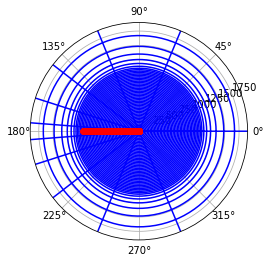

In [13]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[src.surface_wire,1], cylmesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 1900])

(-1000.0, 30.0)

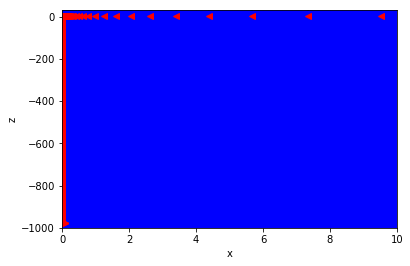

In [14]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([00., 10.])
ax.set_ylim([-1000., 30.])

In [15]:
physprops = casingSimulations.PhysicalProperties(cylmesh, cp)

In [16]:
mesh2D = discretize.CylMesh([cylmesh.hx, 1., cylmesh.hz], x0 = cylmesh.x0)

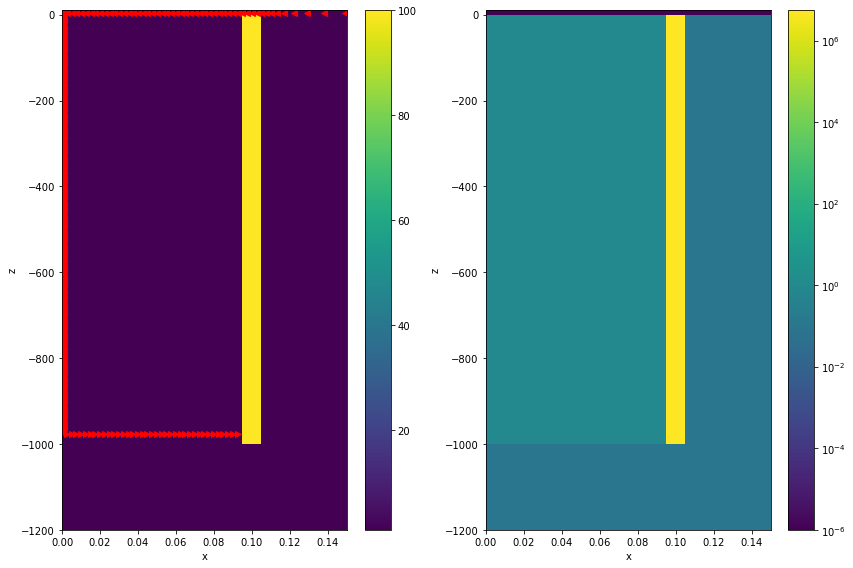

In [18]:
xlim = [0.0, 0.15]
ylim = [-1200., 10.]
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

murplt = physprops.mur.reshape(cylmesh.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[0], mirror=True)[0], ax=ax[0])
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
src.plot(ax=ax[0])

sigmaplt = physprops.sigma.reshape(cylmesh.vnC, order='F')

plt.colorbar(
    mesh2D.plotImage(
        utils.mkvc(sigmaplt[:,0,:]), ax=ax[1], mirror=True, pcolorOpts = {'norm':LogNorm()}
    )[0], ax=ax[1],
    
)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

In [19]:
cp.timeSteps = [(1e-6, 10), (1e-5, 20), (1e-4, 20), (1e-3, 40), (1e-2, 20)] 

In [20]:
# # write out simulation files
# cp.save()
# cylMeshGen.save()
# src.save()

In [21]:
sim3D = casingSimulations.run.SimulationTDEM(
    directory=simDir,
    cp=cp, 
    meshGenerator=cylMeshGen, 
    src=src
)

In [22]:
sim3D.write_py()

Saved 1km_well_10ohm_m_TDEM_downhole/CasingParameters.json
Saved 1km_well_10ohm_m_TDEM_downhole/MeshParameters.json
Saved 1km_well_10ohm_m_TDEM_downhole/Source.json
wrote 1km_well_10ohm_m_TDEM_downhole/simulation.py


In [71]:
sim3D.prob.times.max()

0.24221000000000009

## 2D simulation

In [12]:
mesh2D = meshGen.copy()
mesh2D.hy = np.r_[2*np.pi]

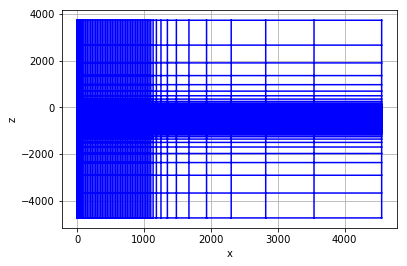

In [13]:
mesh2D.mesh.plotGrid()

In [14]:
src2D = casingSimulations.sources.TopCasingSrc(cp=cp, meshGenerator=mesh2D, directory=simDir)

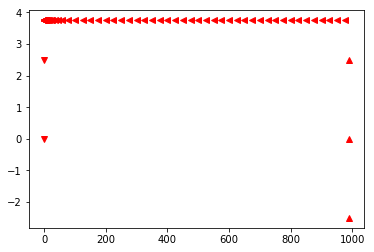

In [15]:
src2D.plot()

In [16]:
sim2D = casingSimulations.run.SimulationTDEM(
    cp=cp, 
    meshGenerator=mesh2D, 
    src=src2D, 
    directory=simDir, 
    fields_filename='fields2D.npy', 
    filename='simulation2D.json'
)

In [17]:
fields2D = sim2D.run()

Validating parameters...
      max x: 4555.86952346, min z: -4738.93997434, max z: 3738.93997434
Saved 1km_well_10ohm_m_TDEM/simulation2D.json
Starting Simulation
   ... Done. Elapsed time : 9.49255084991


## Solve DC for comparison

In [18]:
from SimPEG.EM.Static import DC

In [24]:
src_a = meshGen.mesh.gridFz[sim3D.src.tophole_electrode, :][0, :] - np.r_[0., 0., meshGen.csz/2.] 
src_b = meshGen.mesh.gridFz[sim3D.src.surface_electrode, :][0, :] - np.r_[0., 0., meshGen.csz/2.] 

srcDC = DC.Src.Dipole([], src_a, src_b)
probDC = DC.Problem3D_CC(meshGen.mesh, sigmaMap=sim3D.physprops.wires.sigma, bc_type='Dirichlet', Solver=Pardiso)
surveyDC = DC.Survey([srcDC])

probDC.pair(surveyDC)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [25]:
%%time
fieldsDC = probDC.fields(sim3D.physprops.model)
# np.save('/'.join([simDir, 'fieldsDC.npy']), fieldsDC[:, 'phiSolution'])
# phi = np.load('/'.join([simDir, 'fieldsDC.npy']))
# probDC.sigma = sim3D.physprops.sigma
# fieldsDC = probDC.fieldsPair(cylmesh, surveyDC)
# fieldsDC[:,'phiSolution'] = phi

CPU times: user 40.9 s, sys: 2.44 s, total: 43.3 s
Wall time: 44.6 s


# Plot

In [76]:
prob2D = sim2D.prob
survey2D = sim2D.survey

In [77]:
srctdem = survey2D.srcList[0]

In [78]:
# (mesh2D.mesh.faceDiv * utils.sdiag(prob2D.mesh.area) * srctdem._s_e).nonzero()
rhs = srctdem.getRHSdc(prob2D)

In [79]:
inds = np.abs(rhs) > 1e-10
mesh2D.mesh.gridCC[inds]

array([[  9.87500000e+02,   0.00000000e+00,  -3.75000000e+00],
       [  9.62500000e-02,   0.00000000e+00,  -1.25000000e+00]])

In [80]:
rhs[inds]

array([ 1., -1.])

In [81]:
j_initial = srctdem.jInitial(prob2D)

In [82]:
srctdem.getRHSdc(prob2D)[srctdem.getRHSdc(prob2D).nonzero()]

array([  1.00000000e+00,  -1.00000000e+00,   2.22044605e-16,
        -2.22044605e-16,  -1.11022302e-16,   3.33066907e-16,
        -1.11022302e-16,  -2.22044605e-16,   1.11022302e-16,
        -2.22044605e-16,   1.11022302e-16,  -1.11022302e-16,
        -2.22044605e-16,   1.11022302e-16,  -3.33066907e-16,
         2.22044605e-16,  -1.11022302e-16,   1.11022302e-16,
         1.11022302e-16,   1.11022302e-16,  -1.11022302e-16,
        -1.11022302e-16,  -1.11022302e-16,  -1.11022302e-16,
         1.11022302e-16,  -1.11022302e-16,  -2.22044605e-16,
         1.11022302e-16,  -1.11022302e-16,  -2.22044605e-16,
         3.33066907e-16,  -2.22044605e-16,   1.11022302e-16,
        -1.11022302e-16,   2.22044605e-16,   2.22044605e-16,
        -2.22044605e-16,   1.11022302e-16,   1.11022302e-16,
        -1.11022302e-16,   2.22044605e-16,   2.22044605e-16,
        -2.22044605e-16,  -1.11022302e-16])

In [83]:
import ipywidgets

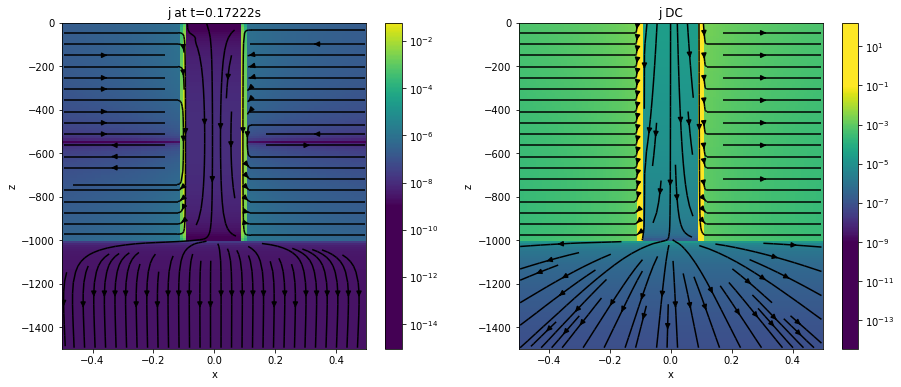

In [87]:
def plotCurrents(tind=0):
    jtdem = fields2D[:,'j',tind]
#     jtdem = j_initial
    jdc = fieldsDC[:, 'j']

    fig, ax = plt.subplots(1,2, figsize=(15, 6))
    
    for i, jplt in enumerate([jtdem, jdc]):
        casingSimulations.plotFace2D(
            mesh2D.mesh,
            jplt, real_or_imag='real', ax=ax[i], range_x=np.r_[-0.5, 0.5],
            range_y=np.r_[-1500., 0.], sample_grid=np.r_[1e-2, 10.],
            logScale=True, clim=[1e-9, 1e-1], 
            mirror=True
        )
    ax[0].set_title('j at t={}s'.format(sim2D.prob.times[tind]))
    ax[1].set_title('j DC')
    plt.show()

ipywidgets.interact(plotCurrents, tind=ipywidgets.IntSlider(min=0, max=len(cp.timeSteps)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=cylMeshGen.mesh.nCy-1, step=1))

In [47]:
casing_faces_x = (
    (sim2D.meshGenerator.mesh.gridFx[:, 0] >= cp.casing_a) &
    (sim2D.meshGenerator.mesh.gridFx[:, 0] <= cp.casing_b) &
    (sim2D.meshGenerator.mesh.gridFx[:, 2] <= cp.casing_z[1]) &
    (sim2D.meshGenerator.mesh.gridFx[:, 2] >= cp.casing_z[0])
)
casing_faces_z = (
    (sim2D.meshGenerator.mesh.gridFz[:, 0] >= cp.casing_a) &
    (sim2D.meshGenerator.mesh.gridFz[:, 0] <= cp.casing_b) &
    (sim2D.meshGenerator.mesh.gridFz[:, 2] <= cp.casing_z[1]) &
    (sim2D.meshGenerator.mesh.gridFz[:, 2] >= cp.casing_z[0])
)

In [48]:
j = fields2D[:, 'j', :]
jA = utils.sdiag(sim2D.meshGenerator.mesh.area) * j

jACasing = utils.sdiag(
    np.hstack([casing_faces_x, casing_faces_z])
) * jA

ixCasing = []
izCasing = []

for ind in range(sim2D.prob.nT+1):
    jxCasing = jACasing[:sim2D.meshGenerator.mesh.nFx, ind].reshape(
        sim2D.meshGenerator.mesh.vnFx[0], sim2D.meshGenerator.mesh.vnFx[2], order='F'
    )
    jzCasing = jACasing[sim2D.meshGenerator.mesh.nFx:, ind].reshape(
        sim2D.meshGenerator.mesh.vnFz[0], sim2D.meshGenerator.mesh.vnFz[2], order='F'
    )

    ixCasing.append(jxCasing.sum(0))
    izCasing.append(jzCasing.sum(0))

ixCasing=np.vstack(ixCasing).T
izCasing=np.vstack(izCasing).T

In [49]:
jxCasing.shape

(130, 446)

In [50]:
zcasing_indz = (
    (sim2D.meshGenerator.mesh.vectorNz >= cp.casing_z[0]) &
    (sim2D.meshGenerator.mesh.vectorNz <= cp.casing_z[1])
)
zcasing_z = sim2D.meshGenerator.mesh.vectorNz[zcasing_indz]

zcasing_indx = (
    (sim2D.meshGenerator.mesh.vectorCCz >= cp.casing_z[0]) &
    (sim2D.meshGenerator.mesh.vectorCCz <= cp.casing_z[1])
)
zcasing_x = sim2D.meshGenerator.mesh.vectorCCz[zcasing_indx]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 446 but corresponding boolean dimension is 447
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 446 but corresponding boolean dimension is 447


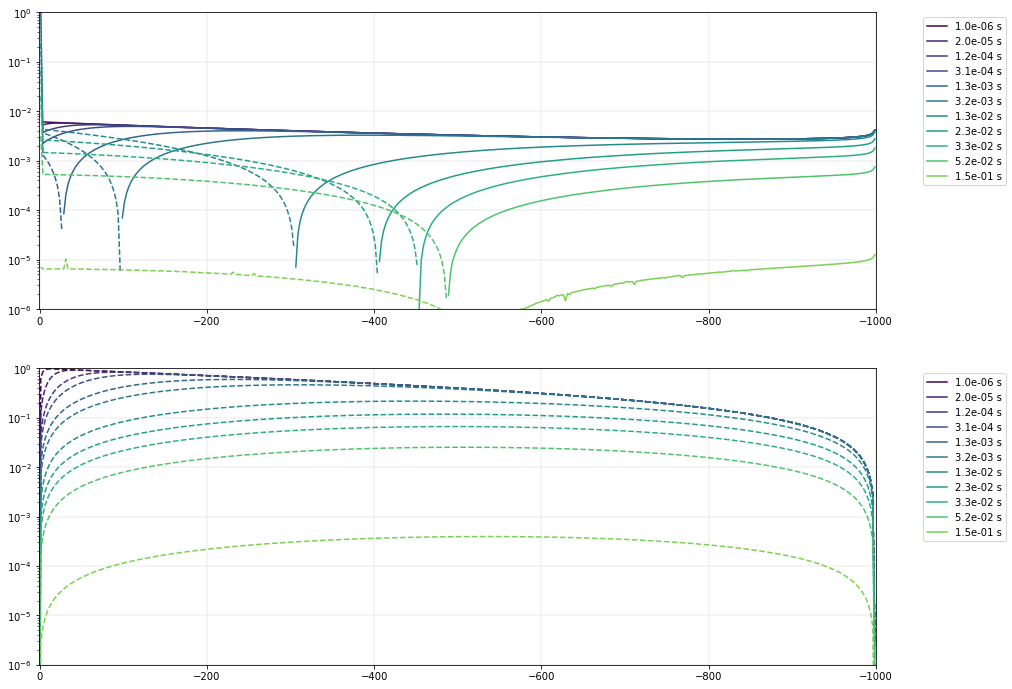

In [52]:
inds = np.arange(1, sim2D.prob.nT+1, step=10)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

color_idx = np.linspace(0, 0.8, len(inds))
for col_id, ind in zip(color_idx, inds):
    ax[0].semilogy(
        sim2D.meshGenerator.mesh.vectorCCz[zcasing_indx], -ixCasing[:, ind][zcasing_indx], '--', color=plt.cm.viridis(col_id)
    )
    ax[0].semilogy(
        sim2D.meshGenerator.mesh.vectorCCz[zcasing_indx], ixCasing[:, ind][zcasing_indx], '-', color=plt.cm.viridis(col_id), 
        label='{:1.1e} s'.format(sim2D.prob.times[ind])
    )
    
    ax[1].semilogy(
        sim2D.meshGenerator.mesh.vectorCCz[zcasing_indz], -izCasing[:, ind][zcasing_indz], '--', color=plt.cm.viridis(col_id)
    )
    ax[1].semilogy(
        sim2D.meshGenerator.mesh.vectorCCz[zcasing_indz], izCasing[:, ind][zcasing_indz], '-', color=plt.cm.viridis(col_id), 
        label='{:1.1e} s'.format(sim2D.prob.times[ind])
    )

for a in ax: 
    a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8])
    a.legend(bbox_to_anchor=(1.05, 1), loc=2)
    a.set_ylim([1e-6, 1e0])
    a.set_xlim([1., -1000.])
    
# plt.plot(izCasing)

# Load up 3D results

In [3]:
meshGen = casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
cp = casingSimulations.load_properties('/'.join([simDir, 'CasingParameters.json']))
jfield = np.load('/'.join([simDir, 'fields.npy']))
src = casingSimulations.load_properties('/'.join([simDir, 'Source.json']), targetModule=casingSimulations.sources)
# simulation = casingSimulations.load_properties(
#     '/'.join([simDir, 'simulationParameters.json']), 
#     targetClass=casingSimulations.run.SimulationFDEM
# )

/Users/lindseyjh/git/python_symlinks/properties/base/base.py:411: RuntimeWarning: Unused properties during deserialization: hy, npadz, npadx, pfz, csz, pfx2, csx2, csx1, domain_x2, nca, ncb, pfx1
  ), RuntimeWarning)


In [4]:
sim3D = casingSimulations.run.SimulationTDEM(cp=cp, meshGenerator=meshGen, src=src)
sim3D.prob.model = sim3D.physprops.model

In [5]:
%%time
fields3D = sim3D.prob.fieldsPair(meshGen.mesh, sim3D.survey)

CPU times: user 3min 17s, sys: 4.59 s, total: 3min 22s
Wall time: 3min 26s


In [6]:
fields3D[:,'jSolution'] = jfield
srcList = sim3D.survey.srcList

In [7]:
cylmesh = meshGen.mesh
src = sim3D.src

In [30]:
fields3D.aliasFields

{'dhdt': ['jSolution', 'E', '_dhdt'], 'j': ['jSolution', 'F', '_j']}

# Plot the Results

In [17]:
import ipywidgets

In [18]:
plotopts = {
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-2000., 10.], 
    'sample_grid':np.r_[10., 10.],
    'logScale':True, 
    'clim':[1e-9, 1e-5]
}

def plotCurrents(tind=0, theta_ind=0):
    jfull = fields3D[:,'j',tind]
    jtdem = casingSimulations.face3DthetaSlice(meshGen.mesh, jfull, theta_ind=theta_ind)
    
    j2D = fields2D[:, 'j', tind]
#     jtdem = j_initial
#     jdc = fieldsDC[:, 'j']

    fig, ax = plt.subplots(1,2, figsize=(15, 8))
    
    for i, jplt in enumerate([jtdem, j2D]):
        casingSimulations.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax[i], range_x=np.r_[0, 1200],
            range_y=np.r_[-1500., 0.], sample_grid=np.r_[10., 10.],
            logScale=True, clim=[1e-9, 1e-4], 
            mirror=False
        )
    ax[1].set_title('j 2D at t={}s'.format(sim2D.prob.times[tind]))
    ax[0].set_title('j 3D at t={}s, theta={:1.1f}'.format(sim2D.prob.times[tind], meshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    plt.show()

ipywidgets.interact(plotCurrents, tind=ipywidgets.IntSlider(min=0, max=len(cp.timeSteps)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=meshGen.mesh.nCy-1, step=1))


TypeError: object of type 'NoneType' has no len()

In [19]:
plotopts = {
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-2000., 10.], 
    'sample_grid':np.r_[10., 10.],
    'logScale':True, 
    'clim':[1e-9, 1e-5]
}

def plotCurrentswDC(tind=0, theta_ind=0):
    jfull = fields3D[:,'j',tind]
    jtdem = casingSimulations.face3DthetaSlice(meshGen.mesh, jfull, theta_ind=theta_ind)
    
    jDC = fieldsDC[:, 'j']
    jDC = casingSimulations.face3DthetaSlice(meshGen.mesh, jDC, theta_ind=theta_ind)

    jdiff = jtdem - jDC
#     jtdem = j_initial
#     jdc = fieldsDC[:, 'j']

    fig, ax = plt.subplots(1,3, figsize=(15, 6))
    
    for i, jplt in enumerate([jtdem, jDC, jdiff]):
        casingSimulations.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax[i], range_x=np.r_[0, 1200],
            range_y=np.r_[-1500., 0.], sample_grid=np.r_[10., 10.],
            logScale=True, clim=[1e-9, 1e-4], 
            mirror=False
        )
        
    ax[2].set_title('j diff at t={}s'.format(sim2D.prob.times[tind]))
    ax[1].set_title('j DC at t={}s'.format(sim2D.prob.times[tind]))
    ax[0].set_title('j 3D at t={}s, theta={:1.1f}'.format(sim2D.prob.times[tind], meshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    
    plt.tight_layout()
    plt.show()

ipywidgets.interact(plotCurrentswDC, tind=ipywidgets.IntSlider(min=0, max=len(cp.timeSteps)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=meshGen.mesh.nCy-1, step=1))


TypeError: object of type 'NoneType' has no len()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115500ed0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x134e88210>], dtype=object)

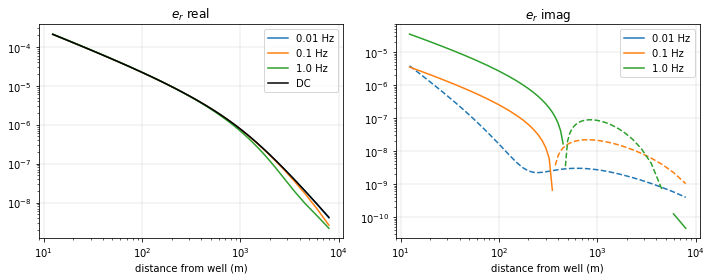

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = utils.mkvc(ax)
    
casingSimulations.view.plotLinesFx(
    cylmesh,
    sim3D.survey.srcList[2:],
    fields3D=fields3D,
    fieldsDC=fieldsDC,
    fieldType='e',
    pltType='loglog',
    ax=ax,
    theta_ind=0,
    xlim=[10., 10000.],
    zloc=0.
)

In [40]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 1e-06,
 'sigma_back': 0.1,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, 0.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

In [8]:
import os

In [9]:
os.path.expanduser('~')

'/Users/lindseyjh'

In [14]:
os.path.abspath(os.path.expanduser('.'))

'/Users/lindseyjh/git/casingResearch/notebooks/casing3D'

In [15]:
downloadpath = [os.path.sep.join([path, f]) for f in filenames]

NameError: name 'filenames' is not defined